In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi,inf,exp,sqrt
from random import shuffle
import operator
from complexFuncs import complexity,DSM_rearrange
import pickle
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from TSP_Functions import calculate_euclidean_distance_matrix,SA_TSP,total_distance,NeighborFunc,plotResults,cal_tsp_complexity, create_TSP_hull, create_TSP_pareto
rng = np.random.default_rng()
from TSP_Functions import *
import docx
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
import random

import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import matplotlib
import plotly.express as px
# def run_t():
url = r'/Users/ricardobortothopker/OneDrive - Massachusetts Institute of Technology/Classes/Thesis/excels/Points for TSP/'
def create_problems_tsp(name=url+r'point count for TSP3.csv'):
    # url2 = r'point count for TSP.csv'
    df = pd.read_csv(name)
    outside = df['outside points'].to_list()
    total = df['points'].to_list()
    totOut = list(zip(total,outside))
    xyArrTot =[]
    for tot,out in totOut:
        xyArrTot.append(create_TSP_hull(out,tot))
    return xyArrTot
def xyArrTot_toDict(xyArrTot,store_dict={},count = 0):
    for i in xyArrTot:
        store_dict['id '+str(count)]=i
        count += 1
    return store_dict
def save_TSP_Problems(xyArrTot,name=url+'TSP Problems3.pkl',store_dict={},count = 0):
    store_dict = xyArrTot_toDict(xyArrTot,store_dict,count)
    # for i in xyArrTot:
    #     store_dict['id '+str(count)]=i
    #     count += 1
    with open(name, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(store_dict, f)
def load_TSP_Problems(url=url+'TSP Problems3.pkl'):
    with open(url,'rb') as f:  # Python 3: open(..., 'rb')
        xyArrDict = pickle.load(f)
    return xyArrDict
def update_TSP_problems(xyArrDict, newxyArrTot,url = url+'TSP Problems3.pkl'):
    keys = list(xyArrDict.keys())
    ids = []
    for i in range(len(keys)):
        ids.append(int(keys[i][3:]))
    lastKey = sorted(ids)[-1]+1
    save_TSP_Problems(newxyArrTot,url,xyArrDict,lastKey)

def visualize_TSP(xyArrDict,show_hull=True,show=True):
    count =0
    for key, i in xyArrDict.items():
        x = i[:,0]
        y = i[:,1]
        fig,ax = plt.subplots()
        ax.scatter(x,y)
        if show_hull:
            hull = ConvexHull(i)
            hullVert = i[np.append(hull.vertices,hull.vertices[0])]
            plt.plot(hullVert[:,0],hullVert[:,1],'--',c='r')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.annotate('Test {}'.format(key),xy=(0.00, 1.02), xycoords='axes fraction')
        if show:
            fig.show()
        else:
            fig.savefig('TSP {}.png'.format(count))
            fig.show()
        count+=1
def dist_matrix_to_csv(xyArrDict,path=url):
    for key, i in xyArrDict.items():
        dist_matrix = calculate_euclidean_distance_matrix(i)
        pd.DataFrame(dist_matrix).to_csv(url+'{}.csv'.format(key))
def run_solve_TSP(xyArrDict,visualize_unsolved_TSP = True,visualize_solved_TSP = True):
    best =[]
    accept=[]
    sols=[]
    it =[]
    bestSol=[]
    totComplexity=[]
    if visualize_unsolved_TSP:
        visualize_TSP(xyArrDict,visualize_unsolved_TSP)
    for key, i in xyArrDict.items():
        
        dist_matrix = calculate_euclidean_distance_matrix(i)
        init = np.array(range(len(i)))
        shuffle(init)
        sol,best_hist,it_hist,accep_hist = SA_TSP(total_distance, NeighborFunc, init, [dist_matrix], [.1],[3,0,.99,1000,1000,2])
        if visualize_solved_TSP:
            plotResults(sol,i,dist_matrix)
        where0 = np.where(sol==0)[0][0]
        sol = np.append(sol[where0:],sol[:where0])
        sols.append(sol)
        bestSol.append(total_distance(sol,dist_matrix))
        best.append(best_hist)
        accept.append(accep_hist)
        it.append(it_hist)
        totComplexity.append(cal_tsp_complexity(i))
    return sols,bestSol,best,accept,it,totComplexity
def create_b_dict(xyArrDict,sols,bestSol,best,accept,it,totComplexity):
    out_dict = {}
    i=0
    for name in xyArrDict.keys():
        # name = 'id ' +str(i)
        out_dict[name] ={}
        out_dict[name]['best']=best[i]
        out_dict[name]['bestSol']=bestSol[i]
        # out_dict[name]['it']=it[i]
        # out_dict[name]['accept']=accept[i]
        out_dict[name]['sol']=sols[i]
        out_dict[name]['xyArr']=xyArrDict[name]
        out_dict[name]['complexity']=totComplexity[i]
        i+=1
    return out_dict
def save_BSF(xyArrDict,sols,bestSol,best,accept,it,totComplexity,url=url+'TSP BSF3.pkl'):
    out_dict = create_b_dict(xyArrDict,sols,bestSol,best,accept,it,totComplexity)
    with open(url, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(out_dict, f)
def load_BSF(name=url+r'TSP BSF3.pkl'):
    with open(name,'rb') as f:  # Python 3: open(..., 'rb')
        sol_dict = pickle.load(f)
    return sol_dict      
def update_BSF(newDict,oldDict,url = url+'TSP BSF3.pkl'):
    out_dict =oldDict
    oKeys = oldDict.keys()
    for nKey in newDict.keys():
        if nKey in oKeys:
            if newDict[nKey]['bestSol']<oldDict[nKey]['bestSol']:
                out_dict[nKey] =newDict[nKey]
                print(nKey+' improved')
        else:
            out_dict[nKey] =newDict[nKey]
    with open(url, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(out_dict, f)
    return out_dict
def plot_bsf(bsfDict):
    for key in bsfDict.keys():
        
        sol = bsfDict[key]['sol']
        xy = bsfDict[key]['xyArr']
        where0 = np.where(sol==0)[0][0]
        sol = np.append(sol[where0:],sol[:where0])
        plotResults(sol,xy,None,key+'\nSol: '+ str(sol)+'\n',True)
def summary_to_csv(bsf,url=url+r'TSP summary.csv'):
    df = pd.DataFrame(bsf).T
    xyArrTot = df['xyArr'].to_list()
    Cdict = cal_tsp_complexityMult(xyArrTot)
    df2 = pd.DataFrame(Cdict,index=df.index)
    df3 = df[['bestSol','sol']]
    out = pd.concat([df3,df2[['C','C1','C2','C3']]],axis=1)
    out.to_csv(url)
def create_and_visualize_TSP():
    xyArrTot = create_problems_tsp()
    xyArrDict = xyArrTot_toDict(xyArrTot)
    
    visualize_TSP(xyArrDict)
    return xyArrTot
def select_problems_to_run(lst,xyArrDict):
    outDict = {}
    for i in lst:
        outDict['id '+str(i)]= xyArrDict['id '+str(i)]
    return outDict
def create_experiments():
    from itertools import combinations
    data = list(range(0,30,2))
    cc = np.array(list(combinations(data,13)))
    np.random.seed(22689)
    random = np.random.randint(2,size=np.shape(cc))
    notRandom = random==0
    problems = cc+random
    problems=np.where(problems!=29,problems,problems+1)
    problems2 = cc+notRandom
    problems2=np.where(problems2!=29,problems2,problems2+1)
    problemsTot = np.concatenate([problems.T,problems2.T],axis=1).T
    
    return problemsTot
def write_problem_to_word(path = r'/Users/ricardobortothopker/OneDrive - Massachusetts Institute of Technology/Classes/Thesis/TSP to solve/TSP Problems/'):
    problemsTot = create_experiments()
    mydoc = docx.Document()
    countTot = 0
    for problem in problemsTot:
        countTot +=1
        count = 0
        probCopy = problem.copy()
        random.seed(countTot)
        shuffle(probCopy)
        for prob in probCopy:
            count +=1
            imageP = path+'TSP {}.png'.format(prob)
            mydoc.add_paragraph('                              Problem  {} from test {} - Practice draft, use pencil or pen. Drawing in this diagram do not count towards the final answer.'.format(count,countTot))
            mydoc.add_picture(imageP, width=docx.shared.Inches(5.78), height=docx.shared.Inches(3.85))
            last_paragraph = mydoc.paragraphs[-1] 
            last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
            mydoc.add_paragraph('                              Problem  {} from test {} - Final Answer, use only the red sharpie in this diagram. This is your final answer for this problem.'.format(count,countTot))
            mydoc.add_picture(imageP, width=docx.shared.Inches(5.78), height=docx.shared.Inches(3.85))
            last_paragraph = mydoc.paragraphs[-1] 
            last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
#             mydoc.add_page_break()
        print(countTot/len(problemsTot))
    sections = mydoc.sections
    for section in sections:
        section.top_margin = Inches(1)
        section.bottom_margin = Inches(1)
        section.left_margin = Inches(0.55)
        section.right_margin = Inches(0.55)
        header = section.header
        paragraph = header.paragraphs[0]
        paragraph.text = "Canonical Experiment in System Complexity and Human Effort"
        paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    mydoc.save(path+r'TSP Problems.docx')

create new problems from file if no argument is given it will create from 'point count for TSP3.csv'
save the problems to 'TSP Problems3.pkl'

In [2]:
#created_new_arr = create_problems_tsp()
#save_TSP_Problems(created_new_arr)

load previous created problems

In [2]:
arrDict = load_TSP_Problems()
del arrDict['id 29']

In [5]:
dist_matrix_to_csv(arrDict)

In [4]:
run_ids = list(range(14,29))
# run_ids = [27]
arrDict = select_problems_to_run(run_ids,arrDict)

In [ ]:

sols,bestSol,best,accept,it,totComplexity = run_solve_TSP(arrDict,False,False)
#bsf = load_BSF()
newDict = create_b_dict(arrDict,sols,bestSol,best,accept,it,totComplexity)
#save_BSF(arrDict,sols,bestSol,best,accept,it,totComplexity)
bsf = load_BSF()
bsf = update_BSF(newDict,bsf)

In [ ]:
bsf=load_BSF()
plot_bsf(bsf)
summary_to_csv(bsf)

In [ ]:
experiments = create_experiments()
print(experiments)

In [12]:
from itertools import combinations
data = list(range(0,30,2))
data[-1] = 30
cc = np.array(list(combinations(data,13)))

In [23]:
problems = np.array([2,4,5,6,7,25,29])
problems=np.where(problems!=29,problems,problems+1)
problems

array([ 2,  4,  5,  6,  7, 25, 30])

In [9]:
df = pd.DataFrame(bsf).T

In [ ]:
df.head()

In [11]:
import bamboolib as bam

In [ ]:
df = df.reset_index()
df

,id 0,id 1,id 2
best,"[[3, 2.4970631305072217, [3, 2, 4, 0, 1, 5]], ...","[[3, 2.197694840626629, [2, 1, 0, 3, 4]], [2.7...","[[3, 2.874758302425244, [5, 1, 0, 4, 2, 3]], [..."
bestSol,2.080613,2.188399,2.209649
sol,"[0, 4, 5, 3, 2, 1]","[0, 2, 3, 4, 1]","[0, 4, 3, 5, 2, 1]"
xyArr,"[[0.16934551549492027, 0.6151305830147565], [0...","[[0.43034991079671026, 0.8525837110831492], [0...","[[0.7390542074260374, 0.4443124412864089], [0...."
complexity,"{'C': 17.666666666666664, 'C1': 7.0, 'C2': 8.0...","{'C': 18.64984471899924, 'C1': 7.0, 'C2': 9.0,...","{'C': 21.333333333333332, 'C1': 8.0, 'C2': 10...."


In [ ]:
write_problem_to_word()

In [12]:
import pandas as pd

In [2]:
path = "/Users/ricardobortothopker/OneDrive - Massachusetts Institute of Technology/Classes/Thesis/excels/Points for TSP/"
df_excel = pd.read_excel(path+"TSP summary.xlsm",sheet_name='TSP summary')

In [3]:
df = df_excel.iloc[2:32].T
rows = ['id','bestSol','sol','C','C1','C2','C3','n-nodes','n-points','sorted sol']
count=1
for i in range(len(rows),len(df),4):
    rows.extend([f'solution_{count}',f'check_{count}',f'cost_{count}',f'time_{count}'])
    count+=1
df['row_names'] = rows
df = df.set_index('row_names')
cols = {}
for i in range(2,32,1):
    cols[i] = f"id {i-2}"
cols[31] = "id 30"
df = df.rename(columns=cols)
df

,id 0,id 1,id 2,id 3,id 4,id 5,id 6,id 7,id 8,id 9,...,id 20,id 21,id 22,id 23,id 24,id 25,id 26,id 27,id 28,id 30
row_names,,,,,,,,,,,,,,,,,,,,,
id,id 0,id 1,id 2,id 3,id 4,id 5,id 6,id 7,id 8,id 9,...,id 20,id 21,id 22,id 23,id 24,id 25,id 26,id 27,id 28,id 30
bestSol,2.080613,2.188399,2.209649,2.383603,2.135481,2.649531,3.03232,3.399789,3.363684,3.332041,...,4.583309,4.32396,4.261522,3.970236,5.045622,4.958354,4.545737,5.135846,4.858339,4.335627
sol,"5,1,2,3,4,6","5,2,1,3,4","5,1,2,3,6,4","5,3,1,7,4,2,6","5,4,2,3,6,1,7","5,3,6,2,7,1,4,8","5,3,10,2,1,4,7,8,9,6","5,3,4,7,11,1,10,2,9,8,6","5,8,3,2,7,9,6,12,11,1,4,10","5,9,6,4,7,12,10,11,14,2,3,8,1,13",...,"5,13,4,3,2,22,9,8,26,27,17,1,14,15,24,16,19,18...","5,15,26,28,27,2,11,7,12,6,20,23,1,8,9,19,16,18...","5,24,12,2,16,1,4,9,22,20,14,29,7,19,13,17,15,6...","5,7,2,18,4,13,1,23,14,26,25,12,30,24,27,22,29,...","5,4,25,19,27,26,23,20,3,31,15,10,6,12,14,16,13...","5,3,30,8,20,28,24,10,19,7,16,15,12,21,6,11,29,...","5,1,13,30,11,3,23,22,12,18,21,16,6,15,8,4,24,1...","5,7,6,30,29,12,24,21,14,23,13,9,3,10,32,27,4,1...","5,1,13,23,34,3,31,30,6,8,33,15,21,19,7,28,10,2...","5,27,21,2,9,17,15,22,7,23,24,31,20,10,3,11,1,1..."
C,17.666667,18.649845,21.333333,23.123872,30.259825,31.313709,37.299689,39.273965,51.34444,53.383697,...,121.711442,123.609317,129.801053,132.187596,137.891134,139.840241,141.438704,143.378534,155.454143,157.531704
C1,7,7,8,9,11,12,14,15,19,20,...,44,45,47,48,50,51,51,52,56,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
time_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
solution_14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
check_14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def get_id_values(df,ident):
    df_temp =df[ident].iloc[10:]
    rows_sol = [f'solution_{j}' for j in range(1,int(len(df_temp)/4))]
    rows_check = [f'check_{j}' for j in range(1,int(len(df_temp)/4))]
    rows_cost = [f'cost_{j}' for j in range(1,int(len(df_temp)/4))]
    rows_time = [f'time_{j}' for j in range(1,int(len(df_temp)/4))]
    df_sol = pd.DataFrame([df_temp.loc[rows_sol]]).T.reset_index().drop(columns=['row_names']).rename(columns={ident:'solution'})
    df_check = pd.DataFrame([df_temp.loc[rows_check]]).T.reset_index().drop(columns=['row_names']).rename(columns={ident:'check'})
    df_cost = pd.DataFrame([df_temp.loc[rows_cost]]).T.reset_index().drop(columns=['row_names']).rename(columns={ident:'cost'})
    df_time = pd.DataFrame([df_temp.loc[rows_time]]).T.reset_index().drop(columns=['row_names']).rename(columns={ident:'time'})
    df_out = pd.concat([df_sol,df_check,df_cost,df_time],axis=1)
    df_out['C'] = [df[ident].loc['C']]*len(df_out)
    df_out['id'] = [ident]*len(df_out)
    df_out['normalized_cost'] = df_out['cost']/df[ident].loc['bestSol']
    df_out = df_out.dropna(thresh=5).reset_index()
    df_out['time/C'] = df_out['time']/df_out['C']
    return df_out

In [5]:
all_df = {}
unified_df = get_id_values(df,'id 0')
for i in range(1,30,1):
    ident = f'id {i}'
    if i == 29:
        ident = 'id 30'
    all_df[ident] = get_id_values(df,ident)
    unified_df = pd.concat([unified_df,all_df[ident]])
unified_df = unified_df.reset_index()

In [6]:
from sklearn.linear_model import LinearRegression
unified_df['log_cost']= np.log(unified_df['cost'])
unified_df['log_C']= np.log(unified_df['C'])
unified_df['log_time']= np.log(unified_df['time'])
log_cost_reg = LinearRegression().fit(unified_df['log_C'].to_numpy().reshape(-1, 1), unified_df['cost'].to_numpy().reshape(-1, 1))
log_time_reg = LinearRegression().fit(unified_df.dropna()['log_C'].to_numpy().reshape(-1, 1), unified_df.dropna()['log_time'].to_numpy().reshape(-1, 1))

In [7]:
print(log_cost_reg.coef_)
print(log_cost_reg.intercept_)
log_cost_reg.predict(np.array([[100]]))

[[1.70667437]]
[-3.0464416]


array([[167.62099511]])

In [8]:
print(log_time_reg.coef_)
print(log_time_reg.intercept_)
log_time_reg.predict(np.array([[100]]))

[[0.62132663]]
[1.55619412]


array([[63.68885731]])

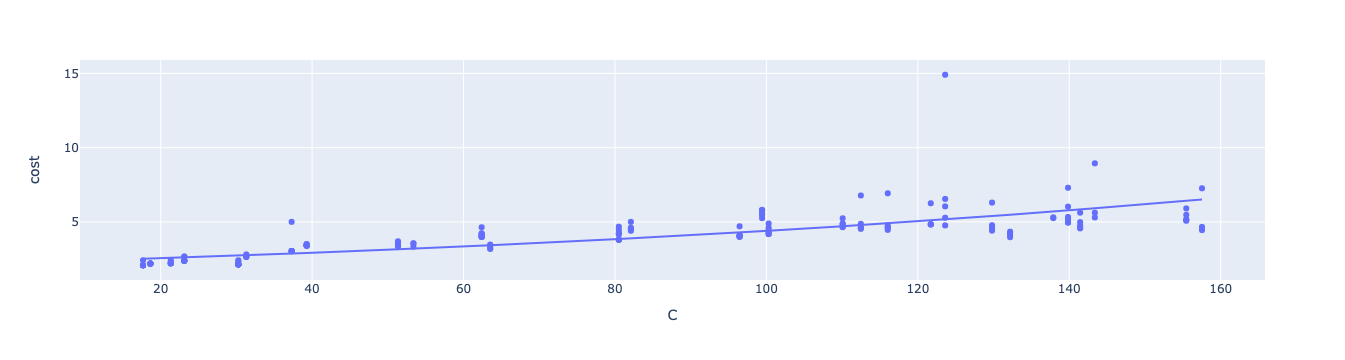

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     462.5
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           5.46e-50
Time:                        16:04:06   Log-Likelihood:                 189.81
No. Observations:                 169   AIC:                            -375.6
Df Residuals:                     167   BIC:                            -369.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3476      0.013     27.621      0.0

In [35]:
# plt.scatter(unified_df['C'],unified_df['cost'])
# fig = px.scatter(x=unified_df['C'], y=unified_df['cost'])
fig = px.scatter(unified_df, x="C", y="cost", log_x=False,log_y=False,trendline="ols", trendline_options=dict(log_x=False,log_y=True))
fig.show()
results = px.get_trendline_results(fig)
results = results.iloc[0]["px_fit_results"].summary()
print(results)

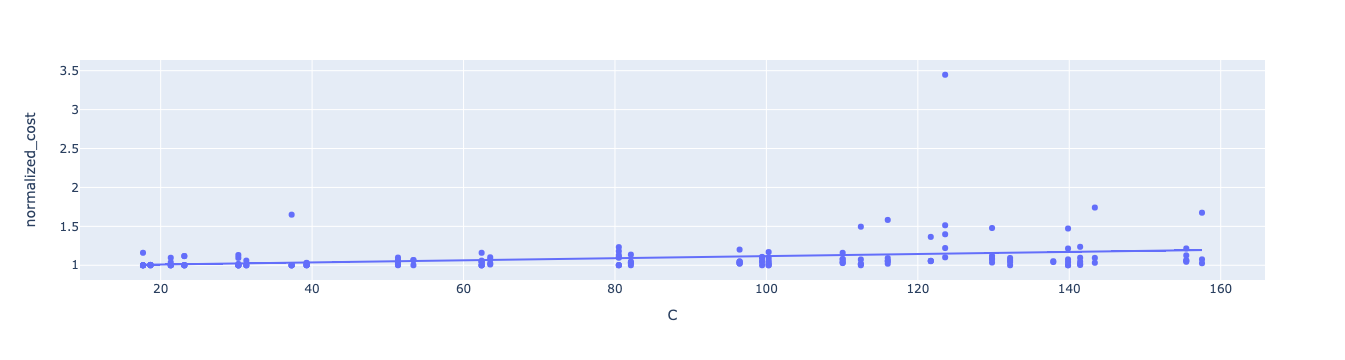

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     12.83
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           0.000446
Time:                        16:06:30   Log-Likelihood:                 19.414
No. Observations:                 169   AIC:                            -34.83
Df Residuals:                     167   BIC:                            -28.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9824      0.034     28.484      0.0

In [36]:
fig = px.scatter(unified_df, x="C", y="normalized_cost", log_x=False,log_y=False,trendline="ols", trendline_options=dict(log_x=False,log_y=False))
fig.show()
results = px.get_trendline_results(fig)
results = results.iloc[0]["px_fit_results"].summary()
print(results)

In [ ]:
unified_df['log_cost'].to_numpy().reshape(-1, 1)

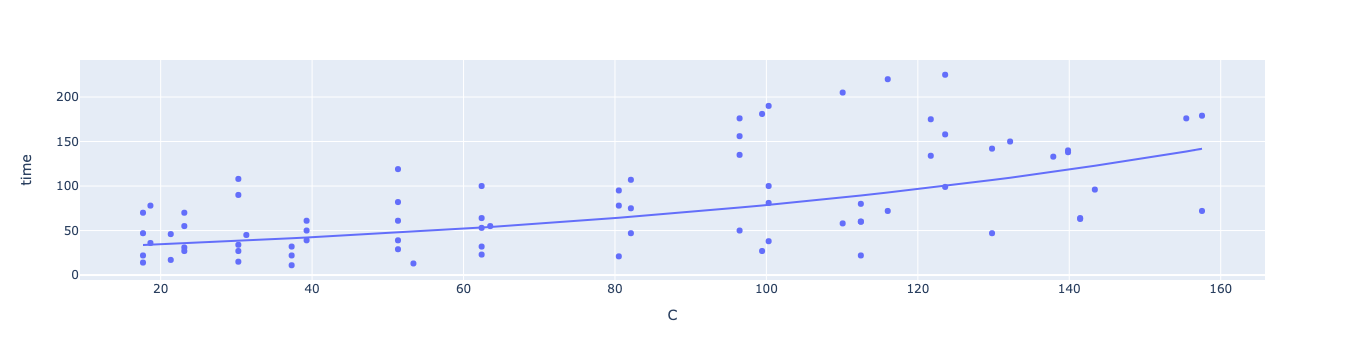

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     40.68
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           1.32e-08
Time:                        16:10:36   Log-Likelihood:                -5.9267
No. Observations:                  77   AIC:                             15.85
Df Residuals:                      75   BIC:                             20.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4491      0.063     23.150      0.0

In [38]:
fig = px.scatter(unified_df, x="C", y="time", log_x=False,log_y=False,trendline="ols", trendline_options=dict(log_x=False,log_y=True))
fig.show()
results = px.get_trendline_results(fig)
results = results.iloc[0]["px_fit_results"].summary()
print(results)

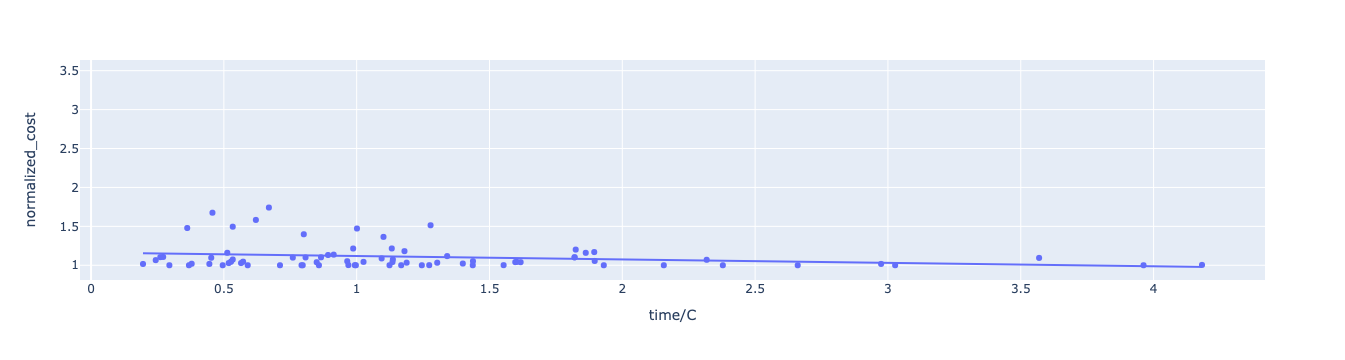

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     3.801
Date:                Wed, 24 Nov 2021   Prob (F-statistic):             0.0550
Time:                        15:57:27   Log-Likelihood:                 30.914
No. Observations:                  77   AIC:                            -57.83
Df Residuals:                      75   BIC:                            -53.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1626      0.033     35.068      0.0

In [32]:
fig = px.scatter(unified_df, x="time/C", y="normalized_cost", log_x=False,log_y=False,trendline="ols", trendline_options=dict(log_x=False,log_y=False))
fig.show()
results = px.get_trendline_results(fig)
results = results.iloc[0]["px_fit_results"].summary()
print(results)

In [54]:
unified_df

,level_0,index,solution,check,cost,time,C,id,normalized_cost,time/C
0,0,0,"1,5,6,4,3,2",True,2.080613,70.0,17.666667,id 0,1.000000,3.962264
1,1,1,"1,5,6,4,3,2",True,2.080613,22.0,17.666667,id 0,1.000000,1.245283
2,2,2,"1,2,3,4,6,5",True,2.080613,47.0,17.666667,id 0,1.000000,2.660377
3,3,3,"1,5,6,4,3,2",True,2.080613,14.0,17.666667,id 0,1.000000,0.792453
4,4,6,"2,1,5,6,4,3",True,2.080613,NaN,17.666667,id 0,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
164,3,11,"21,15,33,19,8,6,30,31,3,34,23,13,5,1,18,12,27,...",True,5.161253,NaN,155.454143,id 28,1.062349,NaN
165,4,12,"21,15,33,19,8,6,30,31,3,34,23,13,5,1,18,12,27,...",True,5.146601,NaN,155.454143,id 28,1.059333,NaN
166,0,4,"28,13,1,32,5,30,18,11,20,31,24,10,3,23,7,22,15...",True,4.661985,179.0,157.531704,id 30,1.075274,1.136279
167,1,5,"26,28,13,31,24,23,7,22,29,25,4,19,1,20,10,15,1...",True,7.263322,72.0,157.531704,id 30,1.675264,0.457051


In [8]:
!jupyter labextension install jupyterlab-plotly

Building jupyterlab assets (production, minimized)


In [11]:
!conda install --yes -c conda-forge plotly==5.4.0

Solving environment: done

## Package Plan ##

  environment location: /Users/ricardobortothopker/opt/anaconda3

  added / updated specs:
    - plotly==5.4.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    plotly-5.4.0               |     pyhd8ed1ab_0         6.9 MB  conda-forge
    tenacity-8.0.1             |     pyhd8ed1ab_0          21 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.9 MB

The following NEW packages will be INSTALLED:

  tenacity           conda-forge/noarch::tenacity-8.0.1-pyhd8ed1ab_0

The following packages will be UPDATED:

  plotly              pkgs/main::plotly-4.14.3-pyhd3eb1b0_0 --> conda-forge::plotly-5.4.0-pyhd8ed1ab_0



plotly-5.4.0         | 6.9 MB    | ##################################### | 100% 
tenacity-8.0.1       | 21 KB     | #############################